In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [229]:
# global parameters

L = 30             # side length
N = L ** 2        # number of sites
q = 5             # number of states per site

In [230]:
# energy function of the potts model with long-range interactions.
def energy(sigma, J):
    # initialize energy to 0
    en = 0
    # loop over sites
    for i in range(N):
        # interaction mask of site i: True at position j iff site i and site j interact.
        delta = (sigma[i] == sigma)
        delta[i] = False
        # energy due to interaction of i with all other sites --> double counting non-diagonal entries
        en += np.dot(J[i], delta)

    # fix double counting before returning
    return 0.5 * en / N

# slow but safe implementation of the energy
def energy_test(sigma, J):
    # initialize energy to 0
    en = 0
    # loop over pairs of sites
    for i in range(N):
        for j in range(i + 1, N):
            # add interaction of sites i and j
            if sigma[i] == sigma[j]:
                en += J[i, j]
    return en / N

In [231]:
# propose a random flip in a random site
def propose_flip(sigma, J):
    # sample a random site and state
    index = np.random.randint(0, N)
    x = np.random.randint(0, q)
    # ensure new state is different than the old one
    while x == sigma[index]:
        x = np.random.randint(0, q)
    # return
    return index, x

In [232]:
# compute change in energy after flipping site i to state new_q
def delta_energy(sigma, J, i, new_q):

    # interaction masks of site i before and after flip
    delta_old = (sigma == sigma[i])
    delta_new = (sigma == new_q)
    delta_new[i], delta_old[i] = False, False

    # energy due to interactions that stop happening after flip
    en_old = np.dot(J[i], delta_old)
    # energy due to interactions that begin happening after flip
    en_new = (np.dot(J[i], delta_new))

    # return change in energy due to flip
    return (en_new - en_old) / N

In [233]:
# metropolis acceptance with symmetric proposal. returns a Boolean
def metropolis(delta_en, t):
    if delta_en < 0:
        return True
    if np.random.uniform(0, 1) < np.exp( - delta_en / t ):
        return True
    return False

In [234]:
# # random symmetric interaction matrix.
# J = np.random.randn(N, N)
# for i in range(N):
#     for j in range(i+1, N):
#         J[i, j] = J[j, i]

# # random nearest-neighbour interaction matrix
J = np.zeros((N, N))
assert np.sqrt(N) == int(np.sqrt(N))    # N must be a perfect square
for i in range(N):
    for j in [(i//L)*L + (i+1)%L, (i//L)*L + (i-1)%L, ((i//L+1)%L)*L + i%L, ((i//L-1)%L)*L + i%L]:
        J[i, j] = np.random.randn()

# # complete ferromagnetic interaction
# J = - np.ones((N, N))

# ferromagnetic nearest-neighbour interaction matrix
k = - 1   # interaction strength
J = np.zeros((N, N))
assert np.sqrt(N) == int(np.sqrt(N))    # N must be a perfect square
for i in range(N):
    for j in [(i//L)*L + (i+1)%L, (i//L)*L + (i-1)%L, ((i//L+1)%L)*L + i%L, ((i//L-1)%L)*L + i%L]:
        J[i, j] = k

In [235]:
# Monte Carlo simulation

# random initial configuration
sigma = np.random.randint(0, q, N)

t = 0.0005
nstep = 5000000
stride = 1000

en = energy(sigma, J)

en_history = []
mag_history = np.zeros((q, nstep+1))
prob_history = []
n_accepted = 0
mag_history[:, 0] = np.bincount(sigma, minlength=q)

for istep in range(nstep):

    # propose random flip
    ind, q_new = propose_flip(sigma, J)
    # compute energy difference
    delta_en = delta_energy(sigma, J, ind, q_new)

    # update probability history
    if delta_en > 0:
        prob_history.append(min(1, np.exp(- delta_en / t)))

    # prepare magnetization update
    mag_history[:, istep+1] = mag_history[:, istep]

    # metropolis update rule
    if metropolis(delta_en, t):
        # update state
        q_old = sigma[ind]
        sigma[ind] = q_new
        n_accepted += 1

        # update energy
        en += delta_en
        # update magnetization history
        mag_history[q_old, istep+1] -= 1
        mag_history[q_new, istep+1] += 1

    # update energy history
    en_history.append(en)

    if istep % stride == 0:
        print(istep, en)

en_history = np.array(en_history)

0 -0.4266666666666667
1000 -0.703333333333329
2000 -0.8722222222222151
3000 -0.9977777777777683
4000 -1.0911111111110992
5000 -1.179999999999986
6000 -1.2211111111110953
7000 -1.2499999999999825
8000 -1.299999999999981
9000 -1.3188888888888692
10000 -1.3366666666666465
11000 -1.3733333333333115
12000 -1.393333333333311
13000 -1.4077777777777554
14000 -1.4244444444444215
15000 -1.4433333333333098
16000 -1.4366666666666434
17000 -1.473333333333309
18000 -1.478888888888864
19000 -1.50555555555553
20000 -1.5222222222221964
21000 -1.527777777777752
22000 -1.5388888888888625
23000 -1.544444444444418
24000 -1.5499999999999734
25000 -1.569999999999973
26000 -1.5755555555555283
27000 -1.5922222222221947
28000 -1.5977777777777502
29000 -1.60777777777775
30000 -1.6044444444444164
31000 -1.6111111111110827
32000 -1.6299999999999712
33000 -1.6366666666666378
34000 -1.6466666666666372
35000 -1.644444444444415
36000 -1.6522222222221925
37000 -1.656666666666637
38000 -1.6677777777777478
39000 -1.66444

In [236]:
burnin = 0
en_history_full = en_history
mag_history_full = mag_history
en_history = en_history[burnin:]
mag_history = mag_history[:, burnin:]

Average energy: -1.9256406515555207


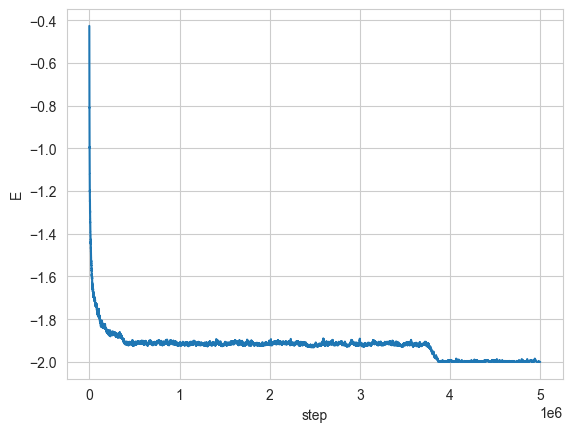

In [237]:
plt.plot(en_history)
plt.xlabel("step")
plt.ylabel("E")
print(f'Average energy: {en_history.mean()}')
plt.show()

Fraction of accepted proposals: 0.0080134


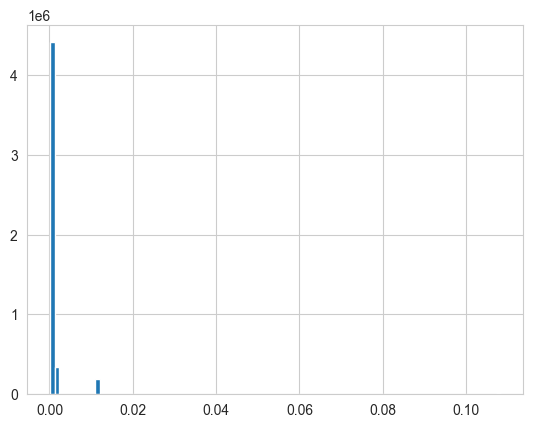

In [238]:
print(f"Fraction of accepted proposals: {n_accepted / nstep}")
plt.hist(prob_history, bins=100)
plt.show()

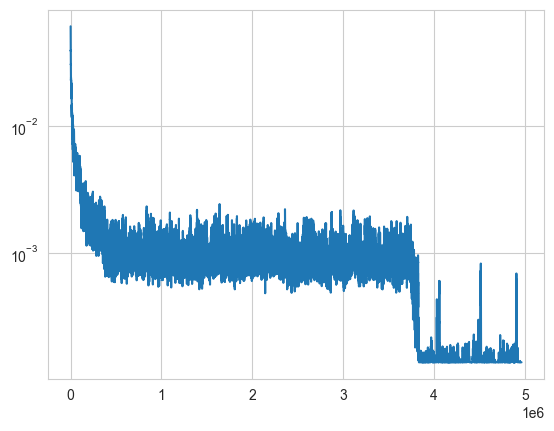

In [239]:
# convolve acceptance probabilities with a kernel to improve visualization
window_size = 1000
kernel = np.ones(window_size) / window_size
smoothed_probs = np.convolve(prob_history, kernel, mode='valid')

# plot
plt.plot(smoothed_probs)
plt.yscale('log')
plt.show()

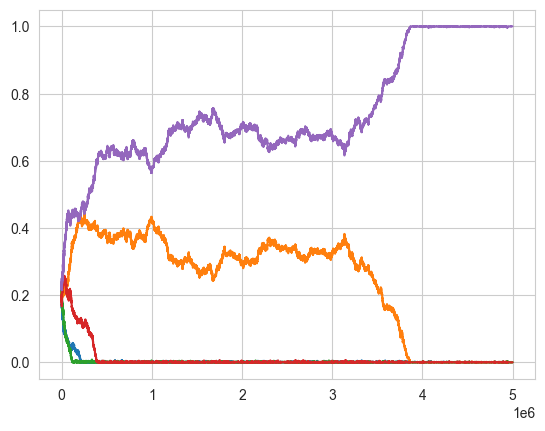

In [240]:
for i in range(q):
    plt.plot(mag_history[i] / N, label=i)
plt.show()